### Import Necessary Libraries

In [1]:
import os
import re
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from einops import rearrange
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timm.utils import ModelEmaV3
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
dataset_dir = "dataset"

listDir = os.listdir(dataset_dir)
listDir = sorted(listDir, key=lambda x: int(re.search(r'sample(\d+).npy', x).group(1)))

imgList, classList = [], []
for file in listDir:
    imgList.append(np.load(os.path.join(dataset_dir, file)))
    classList.append(0)

imgList, classList = np.array(imgList), np.array(classList)

In [3]:
sizeTransform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = Image.fromarray(image.squeeze())
            image = self.transform(image)
        
        return image, label
    
trainDataset = CustomDataset(imgList, classList, transform=sizeTransform)
trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True)

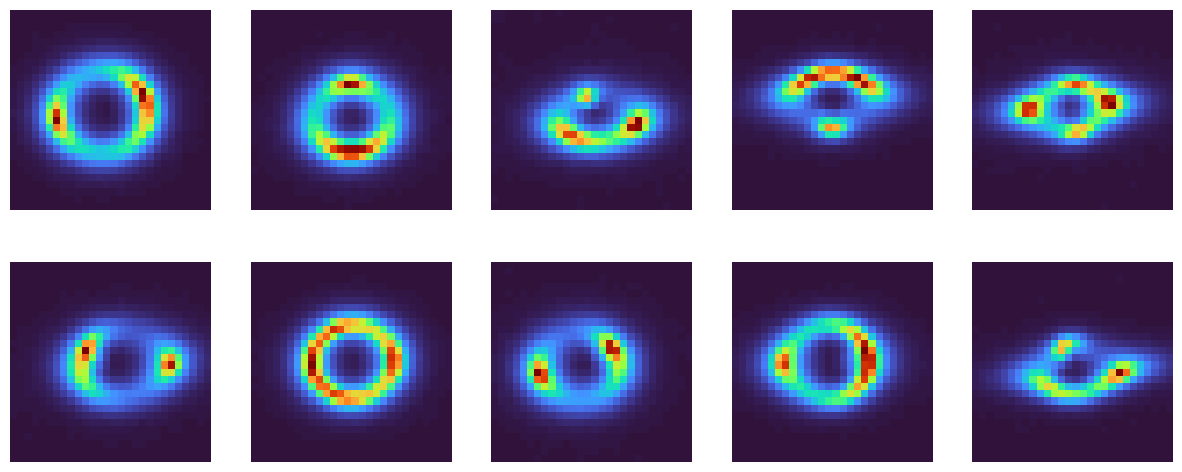

In [4]:
X, y = next(iter(trainLoader))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    ax[i//5][i%5].imshow(X[i].numpy().squeeze(), cmap="turbo")
    ax[i//5][i%5].axis('off')

### Noise Scheduler, Sinusoidal Embedding

In [5]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed=seed)
    torch.cuda.manual_seed(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed=seed)
    
class SinusoidalEmbedding(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings
    
    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

class LinearScheduler(nn.Module):
    def __init__(self, time_steps: int = 1000):
        super(LinearScheduler, self).__init__()
        self.beta = torch.linspace(1e-4, 0.02, time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)
    
    def forward(self, t):
        return self.beta[t], self.alpha[t]

### Neural Network

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, n_channels: int, n_groups: int, dropout_prob: float):
        super(ResidualBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        self.gnorm1 = nn.GroupNorm(num_groups=n_groups, num_channels=n_channels)
        self.gnorm2 = nn.GroupNorm(num_groups=n_groups, num_channels=n_channels)
        self.conv1 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
    
    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

class Attention(nn.Module):
    def __init__(self, n_channels: int, n_heads: int, droput_prob: float):
        super(Attention, self).__init__()
        self.proj1 = nn.Linear(n_channels, n_channels*3)
        self.proj2 = nn.Linear(n_channels, n_channels)
        self.n_heads = n_heads
        self.dropout_prob = droput_prob
    
    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.n_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')
    
class UNetLayer(nn.Module):
    def __init__(self, upscale: bool, attention: bool, n_groups: int, dropout_prob: float, n_heads: int, n_channels: int):
        super(UNetLayer, self).__init__()
        self.resblock1 = ResidualBlock(n_channels, n_groups, dropout_prob)
        self.resblock2 = ResidualBlock(n_channels, n_groups, dropout_prob)
        if upscale: self.conv = nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size=4, stride=2, padding=1)
        else: self.conv = nn.Conv2d(n_channels, n_channels*2, kernel_size=3, stride=2, padding=1)
        if attention: self.attention_layer = Attention(n_channels, n_heads, dropout_prob)

    def forward(self, x, embeddings):
        x = self.resblock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.resblock2(x, embeddings)
        return self.conv(x), x

class Unet(nn.Module):
    def __init__(self, channels: list = [64, 128, 256, 512, 512, 384], 
                 attentions: list = [False, True, False, False, False, True], upscales: list = [False, False, False, True, True, True],
                 n_groups: int = 32, dropout_prob: float = 0.1, n_heads: int = 8, input_channels: int = 1, output_channels: int = 1, 
                 time_steps: int = 1000):
        
        super(Unet, self).__init__()
        self.num_layers = len(channels)
        self.shallow_conv = nn.Conv2d(input_channels, channels[0], kernel_size=3, padding=1)
        out_channels = (channels[-1]//2) + channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbedding(time_steps=time_steps, embed_dim=max(channels))
        
        for i in range(self.num_layers):
            layer = UNetLayer(
                upscale=upscales[i],
                attention=attentions[i],
                n_groups=n_groups,
                dropout_prob=dropout_prob,
                n_channels=channels[i],
                n_heads=n_heads
            )
            setattr(self, f'Layer{i+1}', layer)
    
    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f"Layer{i+1}")
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

### Training Function

In [7]:
def train_ddpm(device: str = "cuda", batch_size: int = 64, time_steps: int = 1000, n_epochs: int = 15, seed: int = -1, ema_decay: float = 0.9999, lr: float = 2e-5, checkpoint_path: str = None):
    set_seed(np.random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    scheduler = LinearScheduler(time_steps=time_steps)
    model = Unet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    
    lossfn = nn.MSELoss(reduction='mean')

    iteration_count, trainLoss = 0, []
    total_iterations = n_epochs * len(train_loader)

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:
        
        for epoch in range(n_epochs):
            batchLoss = []
            for _, (x, _) in enumerate(train_loader):
                x = x.to(device)
                x = F.pad(x, (2, 2, 2, 2))
                time = torch.randint(0, time_steps, (batch_size, ))
                noise = torch.randn_like(x, requires_grad=False)
                alpha = scheduler.alpha[time].view(batch_size, 1, 1, 1).to(device=device)
                x = (torch.sqrt(alpha) * x) + (torch.sqrt(1 - alpha)*noise)
                yHat = model(x, time)
                loss = lossfn(yHat, noise)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batchLoss.append(loss.item())
                ema.update(model)
                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    trainLoss.append(avg_train_loss)
                    pbar.set_postfix_str(f"Loss: {avg_train_loss: .4f}")
                pbar.update(1)
        
            if (epoch+1) % 5 == 0:
                checkpoint = {
                    "weights": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "ema": ema.state_dict()
                }
                torch.save(checkpoint, f"task_4_weights.pth")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ddpm(
    device=device,
    batch_size=16,
    time_steps=1000,
    n_epochs=15
)

Training Progress: 100%|██████████| 9375/9375 [13:32<00:00, 11.54it/s, Loss:  0.0097]


In [10]:
def display_reverse(images: list):
    _, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(device: str = "cuda", checkpoint_path: str = None, time_steps: int = 1000, ema_decay: float = 0.9999):
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model = Unet().to(device=device)
    ema = ModelEmaV3(model, decay=ema_decay)
    model.load_state_dict(checkpoint['weights'])
    ema.load_state_dict(checkpoint['ema'])
    scheduler = LinearScheduler(time_steps=time_steps)
    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp*model(z.cuda(), t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp*model(z.cuda(), [0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

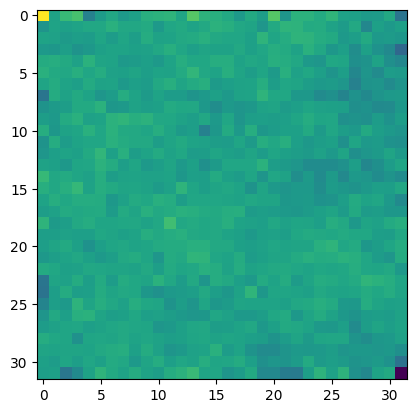

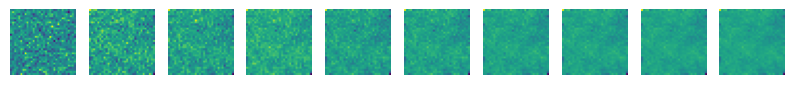

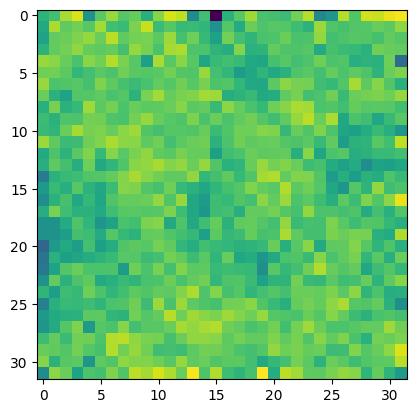

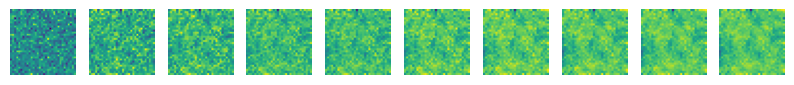

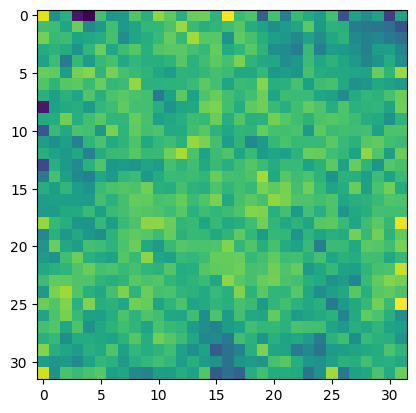

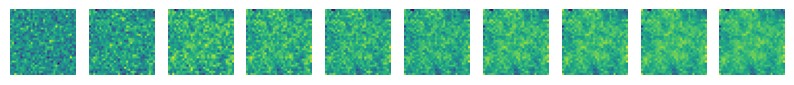

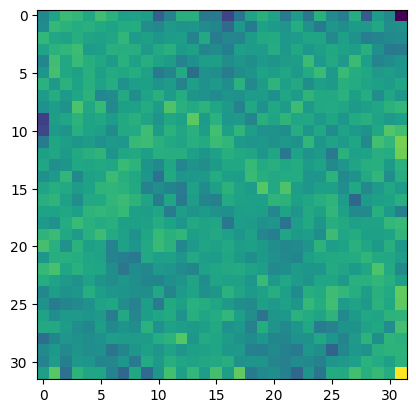

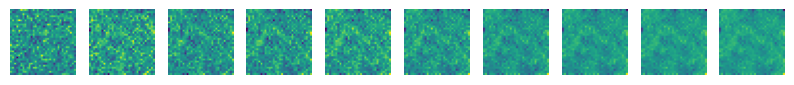

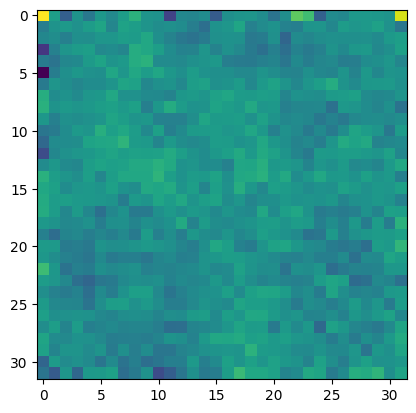

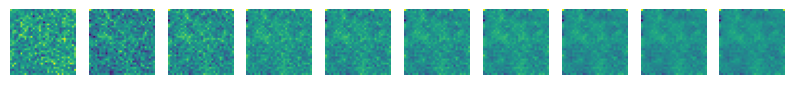

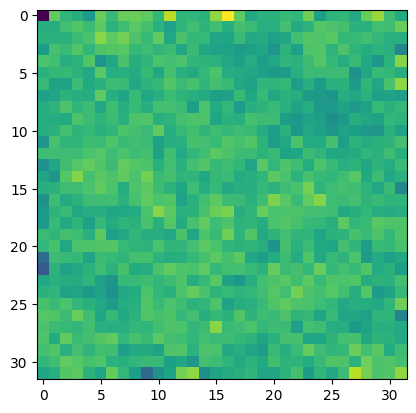

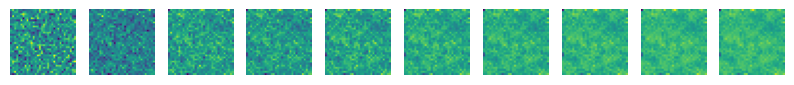

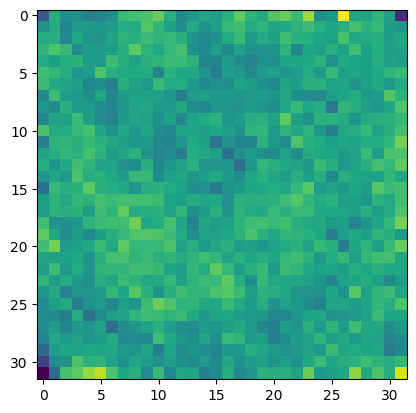

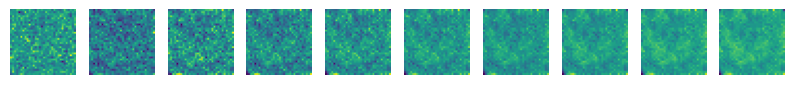

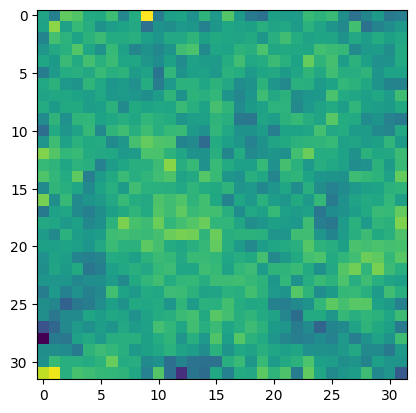

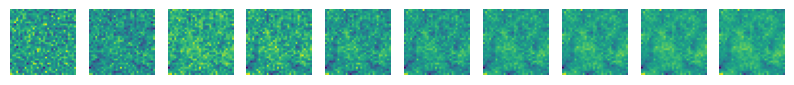

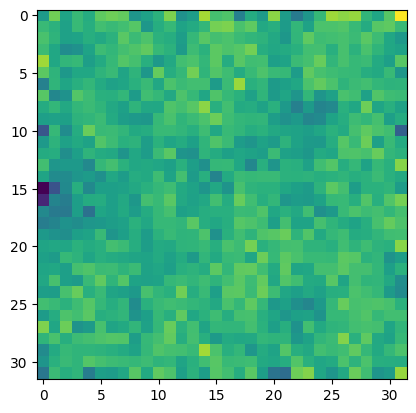

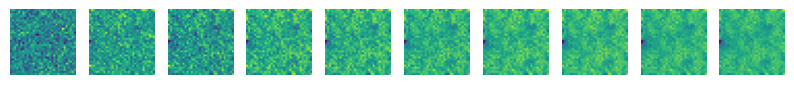

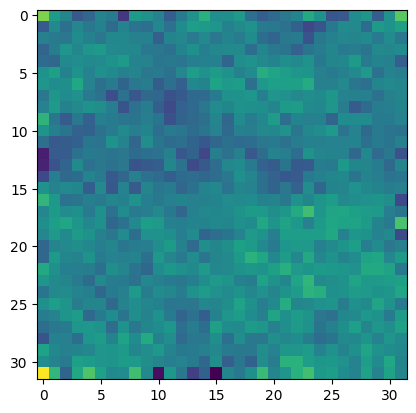

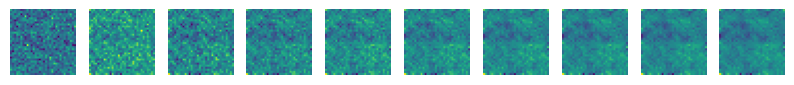

In [11]:
inference(
    device=device,
    checkpoint_path="task_4_weights.pth"
)